### Linear Feed Forward Network

In [1]:
import os
import numpy as np
import pandas as pd
import time
import random
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision
import time
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
from torch.utils.data import TensorDataset, DataLoader
torch.manual_seed(1)

In [2]:
print("chech gpu status")
print("CUDA available?", torch.cuda.is_available())
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

chech gpu status
CUDA available? True


In [3]:
import random
random.seed(10)
torch.manual_seed(66)

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [5]:
test = test.loc[test['target'].notnull(), ]

In [6]:
X_train = train.drop(columns=['target'])
y_train = train['target']

X_train = X_train.to_numpy()
X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32)

In [7]:
X_test = test.drop(columns=['log_ratio_residual'])
y_test = test['log_ratio_residual']

X_test = X_test.to_numpy()
X_test = X_test.astype(np.float32)
y_test = y_test.astype(np.float32)

#################################################################################

In [8]:
BATCH_SIZE = 1000
tensor_x_train = torch.Tensor(X_train) # transform to torch tensor
tensor_y_train = torch.Tensor(y_train)
# Create a dataloader
my_dataset_train = TensorDataset(tensor_x_train,tensor_y_train) 
train_loader = DataLoader(my_dataset_train,batch_size = BATCH_SIZE,shuffle = True)

tensor_x_test = torch.Tensor(X_test) # transform to torch tensor
tensor_y_test = torch.Tensor(y_test)
my_dataset_test = TensorDataset(tensor_x_test,tensor_y_test) 
test_loader = DataLoader(my_dataset_test,batch_size = BATCH_SIZE,shuffle = True)

In [13]:
inputSize = 332
hiddenSize = 128
outputSize = 1

In [14]:
class feedforward(torch.nn.Module):
    def __init__(self, inputSize, hiddenSize, outputSize): 
        super(feedforward, self).__init__() 
        self.linear1 = torch.nn.Linear(inputSize,hiddenSize)
        self.relu = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(hiddenSize, outputSize)

        if torch.cuda.is_available():
             self=self.cuda()

    def forward(self, x):
        out = self.linear1(x)
        out = self.relu(out)
        out = self.linear2(out)
        return out

In [15]:
# train step
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    total_batch_loss = 0
    count= 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(torch.float32).to(device)
        #forward
        output = model(data)
        loss = loss_func(output, target.reshape(-1, 1))
        
        #backward
        optimizer.zero_grad()
        data.requires_grad = True
        loss.backward()
        optimizer.step()
        
        total_batch_loss += loss
        count += 1
        if batch_idx % 50 == 0:
            print(f'Train Epoch: {epoch}',
                f' [{batch_idx * len(data)}/{len(train_loader.dataset)}',
                f'({100. * batch_idx / len(train_loader):.0f}%)]',
                f'\tLoss: {loss.item():.6f}')
    train_losses.append(total_batch_loss.item()/count)
    

In [16]:
# test step
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    count = 0
    with torch.no_grad():
        for data, target in test_loader:   
            data, target = data.to(device), target.to(torch.float32).to(device)
            
            output = model(data)
            test_loss += loss_func(output, target.reshape(-1, 1))
            count += 1
            
        test_loss /= count
        test_losses.append(test_loss)
        print(f'\nTest set: Average loss: {test_loss:.4f}')

In [17]:
train_losses = []
test_losses = []

model = feedforward(inputSize, hiddenSize, outputSize)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
loss_func = nn.MSELoss()
scheduler = StepLR(optimizer, step_size = 2, gamma = 0.6)

In [18]:
import time

start = time.time()
for epoch in range(1, 30 + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()
end = time.time()
end - start

Train Epoch: 1  [0/396710 (0%)] 	Loss: 7089154560.000000
Train Epoch: 1  [50000/396710 (13%)] 	Loss: 250261472.000000
Train Epoch: 1  [100000/396710 (25%)] 	Loss: 167336720.000000
Train Epoch: 1  [150000/396710 (38%)] 	Loss: 700403.187500
Train Epoch: 1  [200000/396710 (50%)] 	Loss: 192086.562500
Train Epoch: 1  [250000/396710 (63%)] 	Loss: 212425.484375
Train Epoch: 1  [300000/396710 (76%)] 	Loss: 81079.390625
Train Epoch: 1  [350000/396710 (88%)] 	Loss: 1253527.500000

Test set: Average loss: 125216960.0000
Train Epoch: 2  [0/396710 (0%)] 	Loss: 188757.234375
Train Epoch: 2  [50000/396710 (13%)] 	Loss: 241864.734375
Train Epoch: 2  [100000/396710 (25%)] 	Loss: 4528.701660
Train Epoch: 2  [150000/396710 (38%)] 	Loss: 60284.210938
Train Epoch: 2  [200000/396710 (50%)] 	Loss: 2669.699219
Train Epoch: 2  [250000/396710 (63%)] 	Loss: 6181.346191
Train Epoch: 2  [300000/396710 (76%)] 	Loss: 2324.849121
Train Epoch: 2  [350000/396710 (88%)] 	Loss: 7416.229492

Test set: Average loss: 18926.

218.70106101036072

In [20]:
torch.save(model.state_dict(), 'LinearFF.pth')

In [22]:
# losses_train = [x.cpu() for x in losses_train]
test_losses = [x.cpu() for x in test_losses]

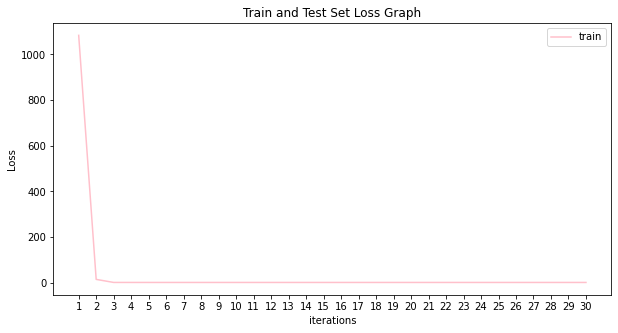

In [23]:
#loss graph
plt.figure(figsize=(10,5))
plt.title("Train and Test Set Loss Graph")
#plt.plot(test_losses,label="test", color='skyblue')
plt.plot(train_losses,label="train", color='pink')
plt.xticks(np.arange(len(test_losses)), np.arange(1, len(test_losses)+1))
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

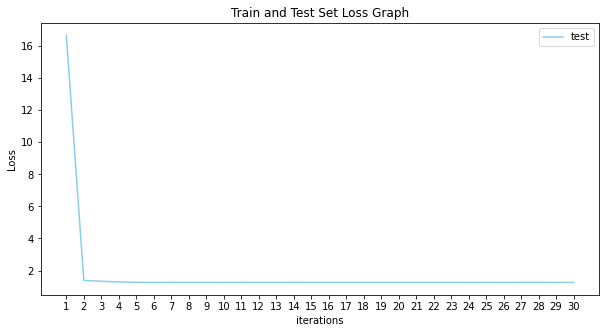

In [24]:
#loss graph
plt.figure(figsize=(10,5))
plt.title("Train and Test Set Loss Graph")
plt.plot(test_losses,label="test", color='skyblue')
#plt.plot(train_losses,label="train", color='pink')
plt.xticks(np.arange(len(test_losses)), np.arange(1, len(test_losses)+1))
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [18]:
model = feedforward(inputSize, hidden1, hidden2, outputSize) # we do not specify pretrained=True, i.e. do not load default weights
model.load_state_dict(torch.load('batchNormFF.pth'))
model.eval()

feedforward(
  (fc1): Linear(in_features=332, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (relu): ReLU()
  (batchnorm1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [25]:
pred_train = model(tensor_x_train.cuda())
pred_test = model(tensor_x_test.cuda())

In [26]:
pred_train = pred_train.cpu()
pred_test = pred_test.cpu()

In [27]:
pred_train = pred_train.detach().numpy()
pred_test = pred_test.detach().numpy()

In [28]:
pred_train = pd.DataFrame(pred_train, columns = ['pred_train'])
pred_test = pd.DataFrame(pred_test, columns = ['pred_test'])

In [29]:
train = pd.read_csv('/home/shared/irisk_bop/data_1022/individual_coverage_modeling/Liability/train_LIAB.csv', index_col = False, low_memory=False)
test = pd.read_csv('/home/shared/irisk_bop/data_1022/individual_coverage_modeling/Liability/test_LIAB.csv', index_col = False, low_memory=False)


In [30]:
test['log_ratio_residual'] = [np.log(a_i / b_i) for a_i, b_i in zip((test['Y_raw'] + 1), test['Y_raw_country_adj'])]
test = test.loc[test['log_ratio_residual'].notnull(), ]

In [31]:
train_pred_df = pd.concat([train[["Rec_ID", "Y_raw_country_adj", "Y_raw"]], pred_train], ignore_index = True, axis = 1)\
.rename(columns = {0: "Rec_ID", 1 : 'Y_raw_country_adj', 2: 'Y_raw', 3: 'pred_train'}).reset_index(drop = True)

In [32]:

test_pred_df = pd.concat([test[["Rec_ID", "Y_raw_country_adj", "Y_raw"]].reset_index(drop = True), pred_test], ignore_index = True, axis = 1)\
.rename(columns = {0: "Rec_ID", 1 : 'Y_raw_country_adj', 2: 'Y_raw', 3: 'pred_test'}).reset_index(drop = True)

In [33]:
train_pred_df['pred_train'] = np.exp(train_pred_df['pred_train']) * train_pred_df['Y_raw_country_adj'] - 1
test_pred_df['pred_test'] = np.exp(test_pred_df['pred_test']) * test_pred_df['Y_raw_country_adj'] - 1

In [34]:
import random
def giniTest(y, py):
    data = pd.DataFrame({"y":y, "py":py})
    random.seed(1)
    n = len(y)
    data['rand_unif'] = np.random.uniform(0.0, 1.0, size = len(y))
    sorted_y = data.iloc[np.argsort(data.py, data.rand_unif), 0]
    i = np.array(range(1, n+1))
    giniIndex = 1-2/(n-1)*(n-sum(sorted_y*i)/sum(sorted_y))
    return giniIndex

def me(y, py):
    ME = None
    ME = sum(y-py)/len(y)
    return ME

def mae(y, py):
    MAE = None
    MAE = sum(abs(y-py))/len(y)
    return MAE

def mse(y, py):
    MSE = None
    MSE = sum((y-py)**2)/len(y)
    return MSE

def rmse(y, py):
    RMSE = None
    RMSE = (sum((y-py)**2)/len(y))**0.5
    return RMSE

def pe(y, py):
    PE = None
    PE = (sum(y)-sum(py))/sum(y)
    return PE

def ccc(y, py):
    CCC = None
    CCC = 2*np.corrcoef(py, y)[0,1]*np.std(y, ddof = 1)*np.std(py, ddof = 1)/(np.var(y, ddof = 1)+np.var(py, ddof = 1)+(sum(y)/len(y)-sum(py)/len(py))**2)
    return CCC

def r2(y, py):
    r2 = None
    r2 = 1- sum((py-y)**2)/sum((y-np.mean(y))**2)
    return r2

def PredictionError(y, py):
    pre = [giniTest(y,py), r2(y,py), ccc(y,py), mse(y, py), rmse(y, py), me(y,py), pe(y,py), mae(y,py)]
    rounding = [round(i, 2) for i in pre]
    return rounding